# Prediction models by codes
In this notebook we consider ICD9 diagnosis and precedure codes as predictors to predict the 30-day readmission rate.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os

In [2]:
%matplotlib inline

In [3]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

## Data reading and splitting

In [4]:
core_dtypes_pd = {'AGE': float,
 'AWEEKEND': float,
 'DIED': float,
 'DISCWT': float,
 'DISPUNIFORM': float,
 'DMONTH': float,
 'DQTR': float,
 'DRG': float,
 'DRGVER': float,
 'DRG_NoPOA': float,
 'DX1': bytes,
 'DX10': bytes,
 'DX11': bytes,
 'DX12': bytes,
 'DX13': bytes,
 'DX14': bytes,
 'DX15': bytes,
 'DX16': bytes,
 'DX17': bytes,
 'DX18': bytes,
 'DX19': bytes,
 'DX2': bytes,
 'DX20': bytes,
 'DX21': bytes,
 'DX22': bytes,
 'DX23': bytes,
 'DX24': bytes,
 'DX25': bytes,
 'DX26': bytes,
 'DX27': bytes,
 'DX28': bytes,
 'DX29': bytes,
 'DX3': bytes,
 'DX30': bytes,
 'DX4': bytes,
 'DX5': bytes,
 'DX6': bytes,
 'DX7': bytes,
 'DX8': bytes,
 'DX9': bytes,
 'DXCCS1': float,
 'DXCCS10': float,
 'DXCCS11': float,
 'DXCCS12': float,
 'DXCCS13': float,
 'DXCCS14': float,
 'DXCCS15': float,
 'DXCCS16': float,
 'DXCCS17': float,
 'DXCCS18': float,
 'DXCCS19': float,
 'DXCCS2': float,
 'DXCCS20': float,
 'DXCCS21': float,
 'DXCCS22': float,
 'DXCCS23': float,
 'DXCCS24': float,
 'DXCCS25': float,
 'DXCCS26': float,
 'DXCCS27': float,
 'DXCCS28': float,
 'DXCCS29': float,
 'DXCCS3': float,
 'DXCCS30': float,
 'DXCCS4': float,
 'DXCCS5': float,
 'DXCCS6': float,
 'DXCCS7': float,
 'DXCCS8': float,
 'DXCCS9': float,
 'ECODE1': bytes,
 'ECODE2': bytes,
 'ECODE3': bytes,
 'ECODE4': bytes,
 'ELECTIVE': float,
 'E_CCS1': float,
 'E_CCS2': float,
 'E_CCS3': float,
 'E_CCS4': float,
 'FEMALE': float,
 'HCUP_ED': float,
 'HOSP_NRD': float,
 'KEY_NRD': float,
 'LOS': float,
 'MDC': float,
 'MDC_NoPOA': float,
 'NCHRONIC': float,
 'NDX': float,
 'NECODE': float,
 'NPR': float,
 'NRD_DaysToEvent': float,
 'NRD_STRATUM': float,
 'NRD_VisitLink': bytes,
 'ORPROC': float,
 'PAY1': float,
 'PL_NCHS': float,
 'PR1': bytes,
 'PR10': bytes,
 'PR11': bytes,
 'PR12': bytes,
 'PR13': bytes,
 'PR14': bytes,
 'PR15': bytes,
 'PR2': bytes,
 'PR3': bytes,
 'PR4': bytes,
 'PR5': bytes,
 'PR6': bytes,
 'PR7': bytes,
 'PR8': bytes,
 'PR9': bytes,
 'PRCCS1': float,
 'PRCCS10': float,
 'PRCCS11': float,
 'PRCCS12': float,
 'PRCCS13': float,
 'PRCCS14': float,
 'PRCCS15': float,
 'PRCCS2': float,
 'PRCCS3': float,
 'PRCCS4': float,
 'PRCCS5': float,
 'PRCCS6': float,
 'PRCCS7': float,
 'PRCCS8': float,
 'PRCCS9': float,
 'PRDAY1': float,
 'PRDAY10': float,
 'PRDAY11': float,
 'PRDAY12': float,
 'PRDAY13': float,
 'PRDAY14': float,
 'PRDAY15': float,
 'PRDAY2': float,
 'PRDAY3': float,
 'PRDAY4': float,
 'PRDAY5': float,
 'PRDAY6': float,
 'PRDAY7': float,
 'PRDAY8': float,
 'PRDAY9': float,
 'REHABTRANSFER': float,
 'RESIDENT': float,
 'SAMEDAYEVENT': bytes,
 'SERVICELINE': float,
 'TOTCHG': float,
 'YEAR': float,
 'ZIPINC_QRTL': float}

In [5]:
ami_index = pd.read_csv(path+'cohorts/ami_index.csv', dtype=core_dtypes_pd)

In [6]:
train_comorb = pd.read_csv(path+'cohorts/ami/comorb_train.csv')
test_comorb = pd.read_csv(path+'cohorts/ami/comorb_test.csv')

In [7]:
train_df = ami_index[ami_index['KEY_NRD'].isin(train_comorb['KEY_NRD'])]
test_df = ami_index[ami_index['KEY_NRD'].isin(test_comorb['KEY_NRD'])]

In [8]:
train_df.shape, test_df.shape

((146771, 151), (48924, 151))

In [9]:
N_train = len(train_df)
N_test = len(test_df)
all_df = pd.concat([train_df, test_df])

In [10]:
del(ami_index, train_comorb, test_comorb)

## Prediction by ICD9 diagnosis codes

In [56]:
from keras.layers import Input, Embedding, concatenate, Reshape, BatchNormalization, add
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam

### Data Preparation

In [12]:
DXs = ['DX'+str(n) for n in range(2, 31)]

In [13]:
DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')
DX_series = DX_series.astype('category')

DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_series = DX_series.cat.rename_categories(range(n_DX_cat))

DX_mat = DX_series.astype(int).values.reshape(len(all_df), 29)

In [14]:
demo_mat = all_df[['AGE', 'FEMALE']].values

age_mean = all_df['AGE'].mean()
age_std = all_df['AGE'].std()

demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std

In [15]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_series = hosp_series.cat.rename_categories(range(len(hosp_cat)))
hosp_array = hosp_series.astype(int).values

In [16]:
DX1_series = all_df['DX1'].astype('category')
DX1_cat = DX1_series.cat.categories
DX1_series = DX1_series.cat.rename_categories(range(len(DX1_cat)))
DX1_array = DX1_series.astype(int).values

In [17]:
DX1_mat = to_categorical(DX1_array, num_classes=len(DX1_cat))

In [18]:
y = all_df['readm30'].values.astype(int)

In [19]:
y_train = to_categorical(y[:N_train])
y_test = to_categorical(y[N_train:])

In [45]:
DX_mat.shape, demo_mat.shape, hosp_array.shape, DX1_mat.shape, y.shape

((195695, 29), (195695, 2), (195695,), (195695, 20), (195695,))

### Model Building

In [57]:
def block(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(nodes)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Dense(nodes)(x)
    x = BatchNormalization()(x)
    
    x = add([input_tensor, x])
    x = Activation('relu')(x)
    return x

In [66]:
input_DX = Input(shape = (29,))
DX_embed_dim = 10
DX_embed = Embedding(input_dim=n_DX_cat, output_dim=DX_embed_dim, input_length=29)(input_DX)
DX_embed = Reshape((29*DX_embed_dim,))(DX_embed)

input_demo = Input(shape=(2, ))

input_DX1 = Input(shape=(len(DX1_cat),))

input_hosp = Input(shape=(1,))
hosp_embed_dim = 5
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1)(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)

merged = concatenate([input_demo, input_DX1, DX_embed, hosp_embed], axis=1)
x = Dense(128, activation='relu')(merged)

for j in range(20):
    x = block(x, 128)

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_demo, input_DX1, input_DX, input_hosp], outputs=prediction)

In [59]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 29)           0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 29, 10)       55530       input_17[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 1, 5)         4370        input_20[0][0]                   
__________________________________________________________________________________________________
input_18 (

In [67]:
adam = Adam()
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
checkpointer = ModelCheckpoint(filepath=model_path+'ami_icd9_1.h5', verbose=0, save_best_only=True, save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1.e-8)
earlystop = EarlyStopping(monitor='val_loss', patience=20)

In [62]:
class_weight = {0:(y_train.shape[0]/sum(y_train[:, 0])), 1:(y_train.shape[0]/sum(y_train[:, 1]))}

In [69]:
hist = model.fit([demo_mat[:N_train, :], DX1_mat[:N_train, :], DX_mat[:N_train, :], hosp_array[:N_train]], y_train, 
                 batch_size=512, epochs=100, callbacks=[checkpointer, reduce_lr, earlystop], class_weight=class_weight, 
                 validation_data=[[demo_mat[N_train:, :], DX1_mat[N_train:, :], DX_mat[N_train:, :], hosp_array[N_train:]], y_test], 
                verbose=2)

Train on 146771 samples, validate on 48924 samples
Epoch 1/100
 - 119s - loss: 1.4950 - acc: 0.5069 - val_loss: 0.7147 - val_acc: 0.2678
Epoch 2/100
 - 49s - loss: 1.3769 - acc: 0.5221 - val_loss: 0.7041 - val_acc: 0.5233
Epoch 3/100
 - 49s - loss: 1.3743 - acc: 0.4762 - val_loss: 0.6860 - val_acc: 0.4561
Epoch 4/100
 - 49s - loss: 1.3721 - acc: 0.5697 - val_loss: 0.6724 - val_acc: 0.5650
Epoch 5/100
 - 49s - loss: 1.3682 - acc: 0.4940 - val_loss: 0.6622 - val_acc: 0.5522
Epoch 6/100
 - 49s - loss: 1.3672 - acc: 0.4630 - val_loss: 0.6866 - val_acc: 0.4657
Epoch 7/100
 - 49s - loss: 1.3645 - acc: 0.5999 - val_loss: 0.6829 - val_acc: 0.5879
Epoch 8/100
 - 49s - loss: 1.3610 - acc: 0.5929 - val_loss: 0.6902 - val_acc: 0.4956
Epoch 9/100
 - 49s - loss: 1.3595 - acc: 0.5870 - val_loss: 0.6785 - val_acc: 0.4469
Epoch 10/100
 - 49s - loss: 1.3538 - acc: 0.5967 - val_loss: 0.6557 - val_acc: 0.5804
Epoch 11/100
 - 49s - loss: 1.3537 - acc: 0.6006 - val_loss: 0.6724 - val_acc: 0.5094
Epoch 12/10

In [70]:
model.load_weights(model_path+'ami_icd9_1.h5')
y_pred = model.predict([demo_mat[N_train:, :], DX1_mat[N_train:, :], DX_mat[N_train:, :], hosp_array[N_train:]], batch_size=256)

In [26]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utils import plot_roc

{0: 0.56196438527563619}

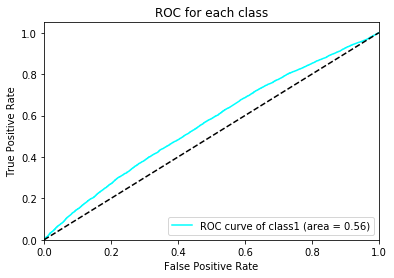

In [71]:
plot_roc(y_pred[:, 0], y_test[:, 0])